# Sentiment Analysis within algorithmic trading

* MA4K8
* Henry Lee

#### Setup, module import

In [333]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date,datetime,timezone, timedelta,time
import matplotlib.pyplot as plt 
from statistics import mean,mode
from scipy.stats import percentileofscore as score
%matplotlib inline  

In [334]:
# Setting some global variables
global global_start_date, global_end_date
global_start_date = '2020-12-15'    #might be worth increasing this date as it takes too long to do things
global_end_date = '2022-12-15'

#### Gather stock list 

In [335]:
# Commented out section as now reading ticker list from "final_tickers.csv"

# ##################################
# # Get ticker list from wikipedia #
# ##################################

# wikiurl="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
# table_class="wikitable sortable jquery-tablesorter"
# response=requests.get(wikiurl)
# print('Status code: ',response.status_code)

# soup = BeautifulSoup(response.text, 'html.parser')
# table=soup.find('table',{'class':"wikitable"})
# df=pd.read_html(str(table))
# # convert list to dataframe
# df = pd.DataFrame(df[0])
# stocks_df = pd.DataFrame(df['Symbol'])     #Can add df['Symbol'].head(20) if testing in a subset of the 500
# stocks_df.columns = ['Ticker']
# stocks_df
# stocks_df.to_csv(r"final_tickers.csv")   

In [336]:
#Stock list setup as dataframe
stocks_df = pd.read_csv('final_tickers.csv')
stocks_df = pd.DataFrame(stocks_df['Ticker'])

#Reorder the stocks list alphabetically
stocks_df.sort_values(by='Ticker',ascending=True,inplace=True)
stocks_df.reset_index(inplace=True,drop=True)
stocks_df;

#### yfinance price data import 

In [337]:
# ######################################################
# # Create dataframe with price values for each ticker #
# ######################################################

# #str(date.today()) is to be used if using today's date:
# #using single date here when choosing basket of stocks, alternate grouping: group_by='ticker':
# df = yf.download(stocks_df['Ticker'].tolist(),start = global_start_date, end = global_end_date)      

# #################
# # Data cleaning #
# #################
# df.rename(columns={'Open':'open','High':'high','Low':'low','Close':'close','Adj Close':'adj close','Volume':'volume'}, inplace=True)

# # Drop rows with all values as NaN
# df.drop(df[df.isnull().all(axis=1)].index,inplace=True)

# #in case there is a miss-match between ticker list of Wiki and yfinance data
# #remove stocks with insufficient data i.e. remove columns that have NaN due to delisting/lisiting time being outside of desired period
# df.dropna(axis=1,inplace=True)   

# # We now have a slightly smaller S&P 500 since we need to ensure that we have sufficient data in the time period 
# print('\n\n',len(df.volume.columns),'\n\n')

# # Final check to ensure no null data will harm the project (should return empty dataframe)
# df_temp = (df['adj close'])
# df_temp[df_temp.isnull().any(axis=1)] 

In [338]:
# # Saving adj close price data to file
# df['adj close'].to_csv('price_data.csv')

In [339]:
prices_df = pd.read_csv('price_data.csv')
prices_df.set_index('Date',inplace=True)

#### Gather valuation metrics, compute metrics
* Price-to-earnings ratio : share price/earnings per share
* Price-to-book ratio : share price/book value (balance sheet)
* Price-to-sales ratio : market cap/company revenue
* Enterprise Value divided by Earnings Before Interest, Taxes, Depreciation, and Amortization (EV/EBITDA)
* Enterprise Value divided by Gross Profit (EV/GP)

In [340]:
#Defining final list of tickers after cleaning, useful for later
final_tickers = prices_df.columns.tolist()

In [341]:
# # Commented out section as now reading ticker info from "ticker_info.csv"

# ticker_info = [yf.Ticker(ticker).info for ticker in final_tickers]
# df_info = pd.DataFrame(ticker_info)
# df_info.to_csv(r"ticker_info.csv")   

In [342]:
df_info = pd.read_csv('ticker_info.csv')
pd.set_option('display.max_columns', None)
df_info;
#pd.set_option('display.max_columns', 20)     -- this is default setting

In [343]:
pe_Ratio = df_info['forwardPE'].copy().tolist()
pb_Ratio = df_info['priceToBook'].copy().tolist()
ps_Ratio = df_info['priceToSalesTrailing12Months'].copy().tolist()
ev_to_ebitda = df_info['enterpriseToEbitda'].copy().tolist()
ev_to_gross_profit = (df_info['enterpriseValue']/df_info['grossProfits']).copy().tolist()

In [344]:
df2_dict = {
    'ticker': final_tickers,
    'adj close': prices_df.tail(1).mean().tolist(),    #noting that we use mean here in case that we judge for value stocks on a large range.  single date usage at the moment with .tail(1) giving 'today'
    'Price-to-Earnings Ratio': pe_Ratio,
    'PE Percentile': 'N/A',
    'Price-to-Book Ratio': pb_Ratio,
    'PB Percentile': 'N/A',
    'Price-to-Sales Ratio': ps_Ratio,
    'PS Percentile': 'N/A',
    'EV/EBITDA': ev_to_ebitda,
    'EV/EBITDA Percentile': 'N/A',
    'EV/GP': ev_to_gross_profit,
    'EV/GP Percentile': 'N/A',
    'RV Score': 'N/A',
}
df2 = pd.DataFrame(df2_dict)

In [345]:
# Checking for null data 
df2[df2.isnull().any(axis=1)];

In [346]:
# Fixing null data with average of that particular column
for col in ['Price-to-Earnings Ratio','Price-to-Book Ratio','Price-to-Sales Ratio', 'EV/EBITDA','EV/GP']:
    df2[col].fillna(df2[col].mean(),inplace=True)  #fills missing values that we did np.nan on with means

In [347]:
# Checking for null data again (should be empty)
df2[df2.isnull().any(axis=1)];

In [348]:
# Filling missing values of percentile scores
metrics = {
    'Price-to-Earnings Ratio':'PE Percentile',
    'Price-to-Book Ratio':'PB Percentile',
    'Price-to-Sales Ratio':'PS Percentile',
    'EV/EBITDA':'EV/EBITDA Percentile',
    'EV/GP':'EV/GP Percentile',
}

for metric in metrics.keys():
    for row in df2.index:
        df2.loc[row,metrics[metric]] = score(df2[metric],df2.loc[row,metric])/100
df2;

In [349]:
# Calculate aggregate value, RV (robust value) Score
for row in df2.index:
    value_percentiles = []
    for metric in metrics.keys():
        value_percentiles.append(df2.loc[row,metrics[metric]])
    df2.loc[row,'RV Score'] = mean(value_percentiles)
df2;

In [350]:
# Final basket selection (smaller RV score better)
df2.sort_values('RV Score',ascending=True,inplace=True)
df2 = df2[:20].copy().reset_index(drop=True)                       
df2;

#### Determine weighting/quantity of each of the stocks to buy using Markowitz Tangency/maximal Sharpe ratio approach

#### Setup for weighting of stocks

In [351]:
df_MT = prices_df
df_MT = df_MT[df2['ticker']]      #note that df2 is still sorted by ascending RV score from before
df_MT;

In [352]:
# Set index for large dataframe to date()
df_MT.index = [datetime.strptime(df_MT.index[i],'%Y-%m-%d').date() for i in range(len(df_MT.index))]

#### Returns and Log Returns

In [353]:
#CAGR, using compound annual growth rate as opposed to mathematical return, avoiding negative log arguments
returns = df_MT/df_MT.shift(1)    
returns.dropna(inplace=True)
logReturns = np.log(returns)  #using log to reduce variation in data

In [354]:
n_sims = 20                                         # lower this if you have a slow computer (10)
av_final_weightings = np.zeros(len(df_MT.columns))
Num_Portfolios = 20000                              # lower this if you have a slow computer (10000)

for p in range(n_sims):

    weight = np.zeros((Num_Portfolios,len(df_MT.columns)))
    expectedLogReturn = np.zeros(Num_Portfolios)
    expectedVolatility = np.zeros(Num_Portfolios)
    sharpeRatio = np.zeros(Num_Portfolios)

    meanLogRet = logReturns.mean()
    Sigma = logReturns.cov()

    for i in range(Num_Portfolios):
        
        #generate rand weight vec
        w = np.array(np.random.random(len(df_MT.columns)))
        w = w/np.sum(w)
        weight[i,:] = w
        
        #expected log return of portfolio
        expectedLogReturn[i] =  np.sum(meanLogRet*w)
        
        #expected volatility (std dev/var)
        expectedVolatility[i] = np.sqrt(np.dot(w.T,np.dot(Sigma,w)))
        
        #sharpe ratio, setting risk free ratio to 0 since we will be maximising this to get the final weightings
        sharpeRatio[i] = expectedLogReturn[i]/expectedVolatility[i]

    maxIndex = sharpeRatio.argmax()
    final_weightings = weight[maxIndex,:]
    final_weightings 
    av_final_weightings += final_weightings

av_final_weightings = av_final_weightings/n_sims
final_weightings = av_final_weightings

In [355]:
# Can use final_weightings from file to maintain relative result consistency in testing

# np.savetxt('final_weightings.csv',final_weightings,delimiter=',')

final_weightings = np.genfromtxt('final_weightings.csv')
final_weightings

array([0.02080601, 0.01864345, 0.01674292, 0.05345602, 0.06099765,
       0.02328663, 0.06978339, 0.0329711 , 0.09886368, 0.0285303 ,
       0.01173718, 0.09485612, 0.10212062, 0.06427118, 0.09112232,
       0.01989526, 0.04848654, 0.05557639, 0.02743093, 0.06042229])

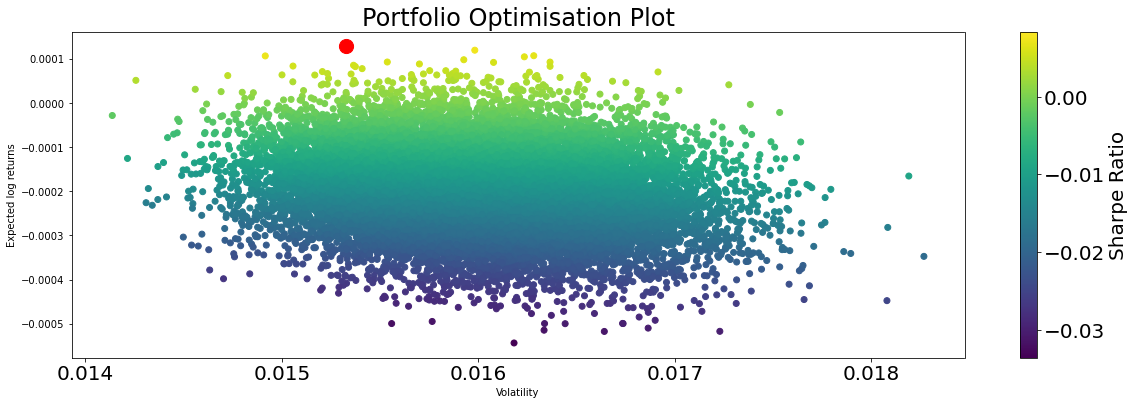

In [356]:
# Plots the last portfolio simulated 
plt.figure(figsize=(20, 6))
plt.scatter(expectedVolatility,expectedLogReturn,c=sharpeRatio)
plt.xlabel('Volatility')
plt.ylabel('Expected log returns')
plt.rcParams.update({'font.size': 20})
plt.xticks(fontsize=20)
plt.title('Portfolio Optimisation Plot')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(expectedVolatility[maxIndex],expectedLogReturn[maxIndex],c='red',s=200)
plt.show()

#### Aggregation of stock basket using optimised weights 
Buy some fraction of stock (as weightings are normalised in both equal weight and optimised cases) and add it to a basket

In [357]:
optimised_basket = np.zeros(len(df_MT))
for i in range(len(df_MT.columns)):
    optimised_basket += final_weightings[i]*np.array(df_MT.iloc[:,i])

In [358]:
equal_weight = np.zeros(len(df_MT))
for i in range(len(df_MT.columns)):
    equal_weight += (1/len(df_MT.columns))*np.array(df_MT.iloc[:,i])

In [359]:
df_MT['optimised basket'] = optimised_basket.tolist()
df_MT['equal weight'] = equal_weight.tolist()
df_MT;

C:\Users\Henry\AppData\Local\Temp\ipykernel_16204\2774762578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MT['optimised basket'] = optimised_basket.tolist()
C:\Users\Henry\AppData\Local\Temp\ipykernel_16204\2774762578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MT['equal weight'] = equal_weight.tolist()


#### Momentum strategy implementation

* Implementation of basic momentum strategy to generate long/short signals

In [360]:
#######################################
# rolling averages added to dataframe #
#######################################
df_MT=df_MT.copy()
df_MT['9-day'] = df_MT['optimised basket'].rolling(9).mean()
df_MT['21-day'] = df_MT['optimised basket'].rolling(21).mean()
df_MT.dropna(inplace=True)

In [361]:
########################################################
# signal indicator for momentum crossing of short/long #
########################################################

def is_momentum_cross(df,t1=9,t2=21):
       
        df=df.copy()
        #signal column if long
        df['signal momentum'] = np.where(df['9-day']>df['21-day'],1,0)  #where 9-day av > 21-day av
       
        #signal column if short
        df['signal momentum'] = np.where(df['9-day']<df['21-day'],-1,df['signal momentum'])  #where 9-day av < 21-day av

###################################
# plot momentum strategy function #
###################################

def plot_momentum(df):

        # Entry points +2 (entering long) and -2 (entering short) positions for momentum strategy plot 
        df=df.copy()
        df['momentum entry'] = df['signal momentum'].diff()

        # Plotting momentum strategy

        df=df.copy()

        plt.rcParams['figure.figsize'] = (18, 6)
        plt.grid(True, alpha = .3)
        plt.plot(df.index,df.loc[:,'optimised basket'], label = 'optimised basket price')
        plt.plot(df.index,df.loc[:,'9-day'], label = '9-day average',linestyle='dashed')
        plt.plot(df.index,df.loc[:,'21-day'], label = '21-day average',linestyle='dotted')
        plt.plot(df[df['momentum entry'] == 2].index, df.loc[:,'9-day'][df['momentum entry'] == 2], '^',
                color = 'g', markersize = 12,label='enter long position')
        plt.plot(df[df['momentum entry'] == -2].index, df.loc[:,'21-day'][df['momentum entry'] == -2], 'v',
                color = 'r', markersize = 12,label='enter short position')
        plt.legend(loc=1,fontsize=15)
        plt.rcParams.update({'font.size': 20})
        plt.xticks(fontsize=20)

        df.drop(columns = ['momentum entry'],inplace=True)

In [362]:
## RUN ##
is_momentum_cross(df_MT)
plot_momentum(df_MT)

KeyError: 'signal momentum'

#### Returns (instantaneous)

In [ ]:
# Supposed return without any intervention (except asset allocation) so somewhat of a market return
MT_daily_pct_returns = df_MT['optimised basket'].pct_change()
MT_cum_daily_pct_returns = (1 + MT_daily_pct_returns).cumprod()-1

EW_daily_pct_returns = df_MT['equal weight'].pct_change()
EW_cum_daily_pct_returns = (1 + EW_daily_pct_returns).cumprod()-1

In [ ]:
print('Final return at time end (optimised %, equal %): ',100*MT_cum_daily_pct_returns[-1],100*EW_cum_daily_pct_returns[-1])

Final return at time end (optimised %, equal %):  4.764344885510563 -11.454815052054823


In [ ]:
# When we apply the momentum strategy, there are 2 outcomes.  In both cases we may profit, but simply we see the difference 
# in how the profit occurs is through either short selling or going long.  If we are long, then we can only profit if the price goes 
# up.  If we are short, then we can only profit if the price goes down.  

MT_daily_pct_returns_mom = MT_daily_pct_returns*df_MT['signal momentum'].iloc[1:]
MT_cum_daily_pct_returns_mom = (1 + MT_daily_pct_returns_mom).cumprod()-1

EW_daily_pct_returns_mom = EW_daily_pct_returns*df_MT['signal momentum'].iloc[1:]
EW_cum_daily_pct_returns_mom = (1 + EW_daily_pct_returns_mom).cumprod()-1

In [ ]:
print('Final return at time end with momentum (optimised %, equal %): ', 100*MT_cum_daily_pct_returns_mom[-1],100*EW_cum_daily_pct_returns_mom[-1])

Final return at time end with momentum (optimised %, equal %):  23.20808118111024 17.24187705152842


#### Plotting returns with this stock basket

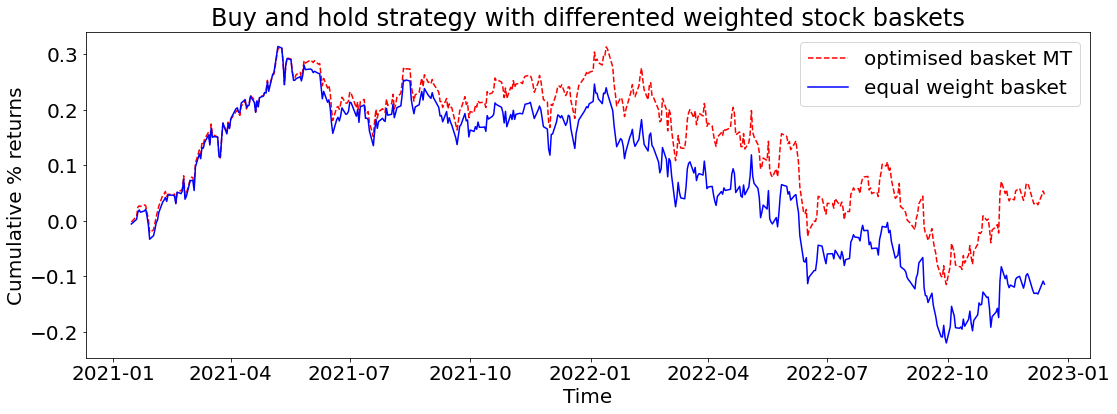

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(df_MT.index,MT_cum_daily_pct_returns,label='optimised basket MT',c='red',linestyle='dashed')
plt.plot(df_MT.index,EW_cum_daily_pct_returns,label='equal weight basket',c='blue')
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Cumulative % returns')
plt.rcParams.update({'font.size': 20})
plt.title('Buy and hold strategy with differented weighted stock baskets')
plt.show()

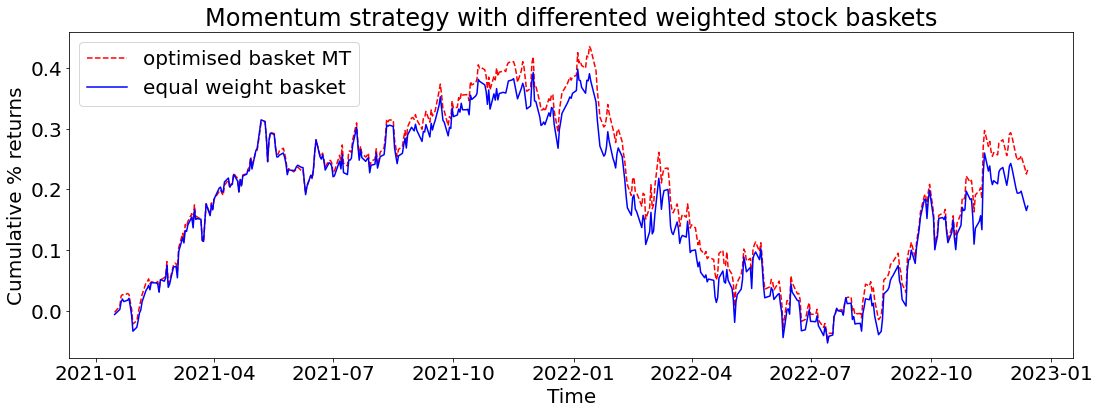

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(df_MT.index,MT_cum_daily_pct_returns_mom,label='optimised basket MT',c='red',linestyle='dashed')
plt.plot(df_MT.index,EW_cum_daily_pct_returns_mom,label='equal weight basket',c='blue')
plt.legend(loc=2)
plt.xlabel('Time')
plt.ylabel('Cumulative % returns')
plt.rcParams.update({'font.size': 20})
plt.title('Momentum strategy with differented weighted stock baskets')
plt.show()

#### PyGoogleNews data collection
* Noting limitation of 100 articles per request
* Gathering data for use in ML 
* https://github.com/kotartemiy/pygooglenews#installation

In [ ]:
from pygooglenews import GoogleNews

#Initiate GoogleNews class
gn = GoogleNews(lang = 'en')

In [ ]:
#fetches news using API and returns news as dictionary
def news_catcher(value_stocks_list):
    
    #initialise dictionary of final output
    news_dict = {key: None for key in value_stocks_list}
    
    for ticker in value_stocks_list:
        search_query = f'{ticker}'   #look at documentation for this bit, could improve search strings

        #first we will get lists of data, one for published date and one for title
        published_list = []
        title_list = []

        #on assumption of maximum 100 news articles per 4 days based on testing with the AAPL stock news, potential to lose some data but minimal
        shifter = timedelta(days=4)   
        
        from_date = datetime.strptime(global_start_date,'%Y-%m-%d').date()               #replace with global start date when done with testing for final simulation!
        final_date = datetime.strptime(global_end_date,'%Y-%m-%d').date()
        break_cond = False

        while True:
            
            # conditional to deal with when shifting from start date exceeds todays date by shortening the shifter value,
            # this can only occur once then break condition is met and while loop will not continue into next iteration
            if from_date + shifter >= final_date:
                shifter = final_date - from_date
                break_cond = True
                
            end_date = from_date + shifter 
            
            search = gn.search(search_query,from_ = str(from_date),to_= str(end_date))   #str(date.today())   #MAXIMUM IS 100 ARTICLES, TRY DOING IN CHUNKS I.E. EVERY 6 Months or something

            published = [datetime.strptime(item['published'][0:16],'%a, %d %b %Y').date() for item in search['entries']]
            title = [item['title']for item in search['entries']]

            #breaks when shifting decelerates fully
            if break_cond:
                break

            from_date = end_date   #note, search function is not inclusive of end date so no overlap here will occur.  Inclusive of start date though.  

            published_list.extend(published)
            title_list.extend(title)
            
        news_dict[f'{ticker}'] = published_list,title_list

        print('Finished news data gathering for ticker: ',ticker)

    return news_dict


In [ ]:
#remove indexing if doing full sim 
value_stocks_list = df2['ticker'].tolist() 

========================================================================================

Commenting following section now we have all news data gathered and saved to news_data folder as .csv

========================================================================================

In [39]:
# news_dict = news_catcher(value_stocks_list)     

In [40]:
# #Convert dictionary to dataframes in a list for each ticker
# def news_to_df(value_stocks_list,news_dict):
#     list_df_news = []
#     for ticker in value_stocks_list:
#         df_news_single = pd.DataFrame(
#             {
#             'date published':news_dict[f'{ticker}'][0],
#             'article title':news_dict[f'{ticker}'][1]
#             }
#         )
#         list_df_news.append(df_news_single)
#     return list_df_news

In [41]:
# #Sort in date order
# list_df_news = news_to_df(value_stocks_list,news_dict)
# for i in range(len(value_stocks_list)):
#     list_df_news[i].sort_values(by=['date published'],inplace=True)

In [42]:
# list_df_news[0]

In [43]:
# #Write to CSV for each stock's dataframe in list of dataframes
# for i in range(10): #change to 50 in full sim
#     list_df_news[i].to_csv('news_data/' + value_stocks_list[i] + '.csv',mode='a', index=False, header=True)

========================================================================================

In [44]:
# Setup for reading news data into a list of dataframes
list_df_news = np.zeros(20).tolist()
for i in range(20): 
    list_df_news[i] = pd.read_csv('news_data/final/' + value_stocks_list[i] + '.csv')
list_df_news[0]

,date published,article title
0,2020-12-18,Zellis Holdings Limited -- Moody's changes Zel...
1,2020-12-20,Is LUMN A Good Stock To Buy Now? - Yahoo Finance
2,2020-12-23,Lumen Technologies: A 5G Play With a 10% Yield...
3,2020-12-23,Sell These Covered Calls For Income And To Low...
4,2020-12-23,AT&T Is Our Top Value Pick For 2021 (NYSE:T) -...
...,...,...
708,2022-12-12,Lumen Technologies Inc (LUMN) Stock Gains 6.35...
709,2022-12-12,3 High Dividend-Paying Stocks In Sweet Spot Of...
710,2022-12-13,"Lumen Technologies, Inc. (NYSE:LUMN) Receives ..."
711,2022-12-13,Why Lumen Technologies Rallied Today - The Mot...


#### Cleaning data (just implementing for some understanding of theory here) (use sklearn in practice) 
* lower case conversion
* punctation removal
* tokenization
* stop word removal 

In [45]:
import string

In [46]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
              "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
              "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
              "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
              "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
              "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
              "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
              "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [47]:
cleaned_news = []
for ticker in range(len(list_df_news)):    #for each company in value stocks list
    company_news = list_df_news[ticker]
    final_words = []
    for row in range(len(company_news)):   #for each news article
        lower_text = company_news.iloc[row,1].lower()
        cleaned_text = lower_text.translate(str.maketrans('','',string.punctuation))
        tokenized_words = cleaned_text.split()

        for word in tokenized_words:
            if word not in stop_words:   #stop word removal 
                final_words.append(word)

    cleaned_news.append(final_words)

cleaned_news;

In [48]:
# Stopwords testing using package instead of manual input 

from nltk.corpus import stopwords
s_words = stopwords.words('English')
#print(s_words)

#### String features conversion to numeric features (3 methods considered here)
* Bag of words
* TFIDF
* Word2Vec 

#### Bag of words:

In [49]:
# Format data for bag of words (doing this for the first company's data indexed with 0)
text_data = (list_df_news[0]['article title']).tolist()

In [50]:
# Bag of words (manually)
# Couple of things to note here: 
#       - I haven't applied any cleaning to the text data except tokenization
#       - sklearn does this for me so we can use that later on
#       - stop words aren't used here

text_data_split = [sentence.split(' ') for sentence in text_data]
bow_manual = set()
for i in range(len(text_data_split)):
    bow_manual = set(text_data_split[i]).union(bow_manual)

numWords = []   #list to hold dictionaries linking new features/word frequency to words
for i in range(len(text_data_split)):
    numWords.append(dict.fromkeys(bow_manual,0))
    for word in text_data_split[i]:
        numWords[i][word] += 1

In [51]:
# Bag of words (using Python modules)
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
# Takes input as list of lists of tokenized text rep each company news

# Use count vectorizer to clean data
bow = CountVectorizer(stop_words='english')

# Fit the data
bow.fit(text_data)

# Get vocab list
bow.get_feature_names_out()

array(['00', '000', '04', ..., 'चत', 'मन', 'रह'], dtype=object)

In [53]:
bow_features = bow.transform(text_data)
#print(bow_features)  #(x,y)   z    || (sentence, word index)     count of word in text

In [54]:
bow_feature_array = bow_features.toarray()
bow_feature_array;

In [55]:
#print(bow.get_feature_names_out(),'\n\n==============\n')
for sentence,feature in zip(text_data,bow_feature_array):
    #print(sentence)
    #print(feature)
    continue

#### TF-IDF:
TF-IDF in NLP is another method.  
Term frequency (TF) is (number of word appearances/total number of words in text):
$$
    \LARGE tf_{i,j} = \frac{n_{i,j}}{\sum_{k}n_{i,j}}
$$

In [56]:
# First we do it manually
# Note that we utilise the results from the previous section when formulating bag of words manually
# Noting same case as manual bag of words i.e. no cleaning has been done, no stop words etc.  

# First computing term frequency 
def computeTF(dict_words,bag):
    tfDict = {}
    bag_count = len(bag)
    for word, count in dict_words.items():
        tfDict[word] = count / float(bag_count)
    return tfDict

In [57]:
tf_list = [computeTF(numWords[i],bow_manual) for i in range(len(numWords))]
#tf_list

Inverse Document Frequency (IDF) is defined as:
$$
\Large idf(w) = log\Bigg(\frac{N}{df_t}\Bigg)
$$

log of number of documents divided by number of documents containing the word w

In [58]:
import math

def computeIDF(documents):
    N = len(documents)

    idfDict = dict.fromkeys(documents[0].keys(),0) #choice of document is arbitrary 
   
    # now dealing with divison by 0 case
    for document in documents:
        for word,val in document.items():
            if val > 0:
                idfDict[word] += 1     #populate idfDict with how many times word appears in each document
    
    for word,val in idfDict.items():
        idfDict[word] = math.log(N/float(val))
    return idfDict

In [59]:
idfs = computeIDF(numWords)

TF-IDF is simply the multiplication of the latter calculated parts:

$$
\Large w_{i,j} = tf_{i,j} \times log\Bigg(\frac{N}{df_i}\Bigg)
$$

In [60]:
def computeTFIDF(tf_bag,idfs):
    tfidf = {}
    for word, val in tf_bag.items():
        tfidf[word] = val*idfs[word]
    return tfidf

In [61]:
tfidf_list = [computeTFIDF(tf_list[i],idfs) for i in range(len(tf_list))]
tfidf_list;

In [62]:
# Application of sklearn for tf-idf method
from sklearn.feature_extraction.text import TfidfVectorizer

In [63]:
#Collecting each news article's vector representation

news_vecs_list = []
for i in range(len(list_df_news)-18):     #just looping through first few companies at once, else memory error
    text_data = (list_df_news[i]['article title']).tolist()
    vectorizer = TfidfVectorizer()
    vecs = vectorizer.fit_transform(text_data)
    feature_names = vectorizer.get_feature_names_out()
    array_vecs_list = vecs.todense().tolist()
    news_vecs_list.append(array_vecs_list)
    # df_tfidf = pd.DataFrame(array_vecs_list,columns=feature_names)

In [64]:
news_vecs_list[1];

#### Word2Vec (self-supervised learning, generates labels itself by backpropagation in NN):

In [65]:
# Word2Vec 
import gensim
from gensim.models import Word2Vec

In [66]:
# Data set-up and preprocess using gensim's simple preprocess and manual work
data_set = list_df_news[0]['article title']

cleaned_data_set = []
for i in range(len(data_set)):   #for each news article
    lower_text = data_set[i].lower()
    lower_text.translate(str.maketrans('','',string.punctuation))
    lower_text = lower_text.replace('-','').replace('?','').replace('!','').replace(')','').replace('(','').replace(';','').replace(':','').replace('"','').replace('\'','').replace('[','').replace(']','')
    cleaned_data_set.append(lower_text)

data_set = pd.Series(cleaned_data_set)
data_set = data_set.apply(gensim.utils.simple_preprocess)
data_set;

In [67]:
# Selecting window size, i.e. neighbourhood from which context words are defined around focus/centre word
model = Word2Vec(
    window=5,
    min_count=2,
    workers=4,   #how many CPU threads to use (logical processors)
    sg=0,         #using skipgrams or cbow (default)
    vector_size = 100    #100 is default, typically 100-400 sized output vectors to rep
)

In [68]:
model.build_vocab(data_set,progress_per=1000)
model.corpus_count
model.epochs
model.train(data_set,total_examples=model.corpus_count,epochs=100);

In [69]:
model.save("word2vec_model.model")

In [70]:
model.wv.most_similar("invest");

In [71]:
model.wv.similarity(w1="stock",w2="stocks");

In [72]:
model.wv['stock'];

#### K-means

* Now we have gone through word embedding techniques, we have our numerical features for K-means input

First we implement K-means manually to get an idea of how this works
* Initialise cluster centers (random)
* Repeat until converge:
* Update cluster labels/cluster membership, assign points to nearest cluster center/centroid
* Update cluster centers (centroids): set center to mean of each cluster (as cluster changes/grows)

Using Euclidean distance for distance measurements

In [73]:
# Let's use our output when we tested TF-IDF method
X = np.array(news_vecs_list[1])  #we can't really visualise since we are in larger than 3 dimensional features

In [74]:
def kmeans_manual(X,k,eps):

    #Repeatability
    np.random.seed(48440101)

    #initialise cluster centres
    
    # p = X.shape[1]       #vector lengths
    # k = 2                #number of clusters

    n = X.shape[0]       #number of data points
    centres = X[np.random.choice(n,k,replace=False)]

    closest = np.zeros(n).astype(int)

    while True:

        old_closest = closest.copy()
        # print(closest)
        distances = np.zeros((n,k))
        
        for i in range(k):
            distances[:,i] = ((X-centres[i])**2).sum(axis=1)**0.5
        
        closest = np.argmin(distances,axis=1)  #find out which data points, by index, belong in which cluster depending on smallest distance to it
        X[closest==0].mean(axis=0)
        
        for i in range(k):
            centres[i,:] = X[closest == i].mean(axis=0)

        #break/convergence condition using Euclidean distance
        if ((closest - old_closest)**2).sum()**0.5 < eps:
            break

    return closest, centres

In [75]:
labels,centres = kmeans_manual(X,2,0.1)
for label in labels:
    print(labels)

[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ...

In [76]:
# Now using sklearn and TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [77]:
# Using TF-IDF
# Note we do not feature scale here for TF-IDF

for i in range(len(list_df_news)):
    documents = list_df_news[i]['article title'].values.astype("U")

    # Bit of manual cleaning helps reduce errors
    cleaned_data_set = []
    for j in range(len(documents)):   #for each news article
        lower_text = documents[j].lower()
        lower_text.translate(str.maketrans('','',string.punctuation))
        lower_text = lower_text.replace('-','').replace('?','').replace('!','').replace(')','').replace('(','').replace(';','').replace(':','').replace('"','').replace('\'','').replace('[','').replace(']','')
        cleaned_data_set.append(lower_text)
    
    documents = pd.Series(cleaned_data_set)

    # More parameters, maybe experiment
    vectorizer = TfidfVectorizer(
        stop_words='english',
        lowercase=True, 
        )
    features = vectorizer.fit_transform(documents)
    
    #apply k means
    #no need for elbow method here as we know we want to classify as negative or positive about company stock
    k=2  
    model = KMeans(n_clusters=k)
    model.fit_predict(features)
    list_df_news[i]['cluster_tfidf']=model.labels_

In [78]:
# Now using gensim and word2vec
import gensim
from gensim.models import Word2Vec, KeyedVectors
from sklearn.preprocessing import StandardScaler

In [79]:
# Using word2vec

# Initialise the standard scaler class
scaler = StandardScaler()


#loop through all companies here 
for h in range(len(list_df_news)):

    # Data set-up and preprocess using gensim's simple preprocess and manual work
    data_set = list_df_news[h]['article title']

    cleaned_data_set = []
    for y in range(len(data_set)):   #for each news article
        lower_text = data_set[y].lower()
        lower_text.translate(str.maketrans('','',string.punctuation))
        lower_text = lower_text.replace('-','').replace('?','').replace('!','').replace(')','').replace('(','').replace(';','').replace(':','').replace('"','').replace('\'','').replace('[','').replace(']','')
        cleaned_data_set.append(lower_text)

    data_set = pd.Series(cleaned_data_set)
    data_set = data_set.apply(gensim.parsing.preprocessing.remove_stopwords)
    data_set = data_set.apply(gensim.utils.simple_preprocess)

    # Model creation
    # Selecting window size, i.e. neighbourhood from which context words are defined around focus/centre word
    model = Word2Vec(
        window=5,
        min_count=0,
        workers=6,   #how many CPU threads to use (Ryzen 5 3600 has 6)
        sg=0,         #using skipgrams or cbow (default)
        vector_size = 100    #100 is default, typically 100-400 sized output vectors to rep
    )

    model.build_vocab(data_set,progress_per=1000)
    #epochs: how many times to go through entire dataset
    model.train(data_set,total_examples=model.corpus_count,epochs=100)
    model.save("word2vec_model.model")   #saves model

    #combine word vectors using simple mean average
    company_news_storage = []
    for i in range(len(data_set)):
        # print('new i:', i)
        sentence_storage = []
        for j in range(len(data_set[i])):
            try:
                sentence_storage.append(model.wv[data_set[i][j]])
                # print(data_set[i][j])
            except: 
                print('Skipping word...')

        company_news_storage.append(np.nanmean(np.array(sentence_storage),axis=0))

    features_w2v = [company_news_storage[p].tolist() for p in range(len(company_news_storage))]

    #application of standard scaler to features
    features_w2v = scaler.fit_transform(features_w2v)

    #Apply k means
    #no need for elbow method here as we know we want to classify as negative or positive about company stock
    k=2  
    model = KMeans(n_clusters=k)
    model.fit(features_w2v)
    list_df_news[h]['cluster_word2vec']=model.labels_

In [80]:
list_df_news[0].head(10)

,date published,article title,cluster_tfidf,cluster_word2vec
0,2020-12-18,Zellis Holdings Limited -- Moody's changes Zel...,0,0
1,2020-12-20,Is LUMN A Good Stock To Buy Now? - Yahoo Finance,0,1
2,2020-12-23,Lumen Technologies: A 5G Play With a 10% Yield...,0,1
3,2020-12-23,Sell These Covered Calls For Income And To Low...,0,1
4,2020-12-23,AT&T Is Our Top Value Pick For 2021 (NYSE:T) -...,0,1
5,2020-12-24,A Mathematician Has Finally Solved the Infamou...,0,0
6,2020-12-28,Should You Scoop Up These 10 Highest-Yielding ...,0,1
7,2020-12-30,Here's My Top Stock to Buy for 2021 - The Motl...,0,1
8,2021-01-08,How Safe Is Lumen Technologies' Massive 10% Di...,0,1
9,2021-01-08,Why Lumen Technologies Stock Sank 24.5% in 202...,0,1


#### Applying our ML output

In [ ]:
list_df_news_signals = [dfs[['date published','cluster_tfidf','cluster_word2vec']] for dfs in list_df_news]

In [ ]:
# Converting our ML output (1s and 0s) into short/long position trade signals
# ASSUMPTION: positive news = 1 (long/buy), negative news = -1 (short/sell)

for i in range(len(list_df_news_signals)):
    list_df_news_signals[i] = list_df_news_signals[i].copy()
    list_df_news_signals[i]['cluster_tfidf'][list_df_news_signals[i].loc[:,'cluster_tfidf']==0] = -1
    list_df_news_signals[i]['cluster_word2vec'][list_df_news_signals[i].loc[:,'cluster_word2vec'] == 0] = -1

C:\Users\Henry\AppData\Local\Temp\ipykernel_16204\4204177153.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_df_news_signals[i]['cluster_tfidf'][list_df_news_signals[i].loc[:,'cluster_tfidf']==0] = -1
C:\Users\Henry\AppData\Local\Temp\ipykernel_16204\4204177153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_df_news_signals[i]['cluster_word2vec'][list_df_news_signals[i].loc[:,'cluster_word2vec'] == 0] = -1


In [ ]:
# Can swap/comment/uncomment certain lines if want to use TF-IDF instead of word2vec
# Fixing the issue with multiple signals for a given date using mode

list_df_news_signals_final = []

for i in range(len(list_df_news_signals)):
    
    # Some dates have multiple signals so we take the mode so that it is only 1 signal per date
    tfidf_df = list_df_news_signals[i][['date published','cluster_tfidf']].copy().groupby(['date published'],as_index=False)['cluster_tfidf'].apply(mode)
    tfidf_df = tfidf_df.iloc[0:-1]

    # word2vec_df = list_df_news_signals[i][['date published','cluster_word2vec']].copy().groupby(['date published'],as_index=False)['cluster_word2vec'].apply(mode)
    # word2vec_df = word2vec_df.iloc[0:-1]

    list_df_news_signals_final.append(tfidf_df)

    # list_df_news_signals_final.append(word2vec_df)

# We convert our indices to datetime objects and set the index as the dates for later
for i in range(len(list_df_news)):
    for j in range(len(list_df_news_signals_final[i]['date published'])):
        list_df_news_signals_final[i].loc[j,'date published'] = datetime.strptime(list_df_news_signals_final[i]['date published'].iloc[j],'%Y-%m-%d').date()
    list_df_news_signals_final[i].set_index('date published',inplace=True)

In [ ]:
# Assign empty news signal columns, intialise as np.nan (for each company so at + 20*2 cols of signals if using both tfidf and word2vec)

# Starting index and ending index to match news and price data first (there will be some missing days of news signals in between, we will deal with later)
idx_start = df_MT.index[0]  
idx_end = df_MT.index[-1]

# Re-define list of signal dataframes with correct dates for addition to larger dataframe
list_df_news_signals_final = [list_df_news_signals_final[i].loc[idx_start:idx_end] for i in range(len(list_df_news_signals_final))]

In [ ]:
# Initialise new signal columns for news data in large dataframe
for i in range(len(value_stocks_list)):
    df_MT['signal '+value_stocks_list[i]] = np.nan

In [ ]:
# large dataframe indices as a set for use in loop
idx_master = set(df_MT.index)

# Populate final dataframe with news signals 
for i in range(len(list_df_news_signals_final)):
    
    # Set index to index news data into large dataframe using Python set functions
    idx = list_df_news_signals_final[i].index
    shared_idx = list(set(idx) & idx_master)
    
    # Loop through company column, setting signals for each day that signal present 
    for j in range(len(shared_idx)):
        df_MT.loc[shared_idx[j],'signal '+value_stocks_list[i]] = list_df_news_signals_final[i]['cluster_tfidf'].loc[idx[j]]                        #TF-IDF
        # df_MT.loc[shared_idx[j],'signal '+value_stocks_list[i]] = list_df_news_signals_final[i]['cluster_word2vec'].loc[idx[j]]                   #word2vec
        
    # Fill forward np.nan values in data i.e. carry on trading at same signal until something changes                           
    df_MT['signal '+value_stocks_list[i]].ffill(axis = 0,inplace=True)

    # Finally, remove and np.nan that remain (at the beginning of the column i.e. start trading at initial time with np.nan signal).
    # Replace this np.nan value with 0 indicating not in long nor short position 
    df_MT['signal '+value_stocks_list[i]].fillna(0,inplace=True)

#### Final returns with strategy

In [ ]:
MT_total_return = np.zeros(len(df_MT))
EW_total_return = np.zeros(len(df_MT))

for i in range(len(value_stocks_list)):
    # Basic daily return of stock i
    MT_pct_returns = df_MT[value_stocks_list[i]].pct_change()

    # Cumulative returns based on signal of stock i 
    MT_pct_returns_signal = MT_pct_returns * df_MT['signal '+value_stocks_list[i]].iloc[1:]
    MT_cum_pct_returns = (1+MT_pct_returns_signal).cumprod()-1

    # Add returns column to dataframe (in dec. not pct.)
    df_MT = df_MT.copy()
    df_MT.loc[:,'return '+value_stocks_list[i]] = MT_cum_pct_returns

    # Add up total return and compute weighted cum returns then sum (this is fine as we are essentially averaging over the number of value stocks in a normalised weighted setting)
    MT_total_return += final_weightings[i]*np.array(MT_cum_pct_returns)
    EW_total_return += (1/len(value_stocks_list))*np.array(MT_cum_pct_returns)

In [ ]:
print('Final return at time end with news (optimised %, equal %): ',100*MT_total_return[-1], 100*EW_total_return[-1])   

Final return at time end with news (optimised %, equal %):  -10.633134546301077 4.460576097051897


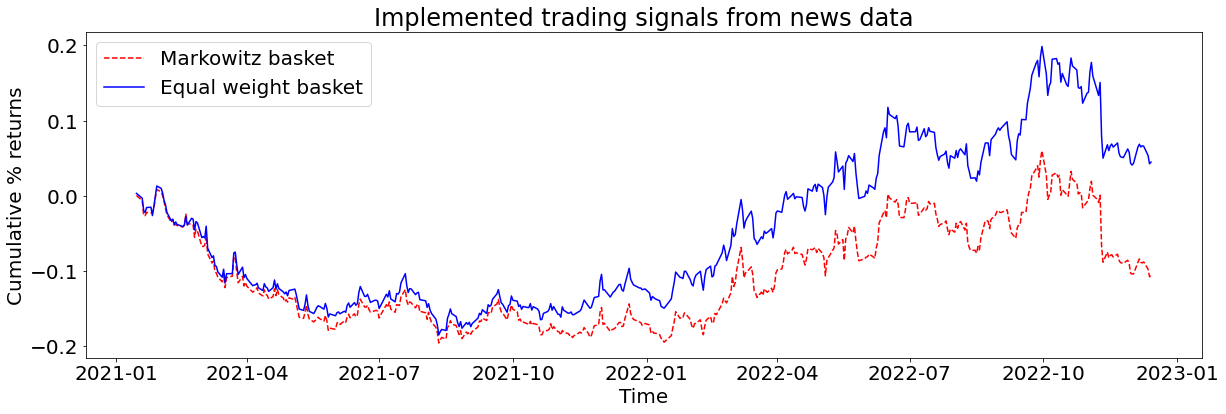

In [ ]:
# Plot returns, compare with previous optimised basket
plt.figure(figsize=(20, 6))
plt.plot(df_MT.index,MT_total_return,label='Markowitz basket',c='red',linestyle='dashed')  
plt.plot(df_MT.index,EW_total_return,label='Equal weight basket',c='blue')
plt.legend(loc=2)
plt.xlabel('Time')
plt.ylabel('Cumulative % returns')
plt.rcParams.update({'font.size': 20})
plt.title('Implemented trading signals from news data')
plt.show()